In [1]:
# I had to manually input the preprocessor into the same notebook as it was not importing from the .py file.
import h5py
import numpy as np
from transformers import AutoTokenizer

# Load Qwen tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load Lotka-Volterra dataset
def load_data(file_path="lotka_volterra_data.h5"):
    with h5py.File(file_path, "r") as f:
        trajectories = f["trajectories"][:]
        time_points = f["time"][:]
    return trajectories, time_points

# LLMTIME Preprocessing Function
def preprocess_time_series(data, alpha=10, decimal_places=2):
    """
    Converts numerical time series into a text-based format compatible with Qwen's tokenizer.

    Parameters:
      data: input the Lotka-Volterra dataset
      alpha: scales the data by alpha
      decimal_places: Rounds to 'decimal_places'

    Returns:
      Formats time series using commas (,) for variables and semicolons (;) for timesteps.
    """
    # Scale and round values
    scaled_data = np.round(data / alpha, decimals=decimal_places)

    # Convert to formatted text sequence
    sequence_strings = []
    for system in scaled_data:  # Loop over each system
        formatted_timesteps = [",".join(map(str, timestep)) for timestep in system]
        sequence_strings.append(";".join(formatted_timesteps))  # Join timesteps

    return sequence_strings

# Tokenize sequence using Qwen
def tokenize_sequence(sequence):
    """
    Tokenizes the preprocessed sequence using Qwen2.5 tokenizer.
    """
    tokenized = tokenizer(sequence, return_tensors="pt")["input_ids"]
    return tokenized.tolist()[0]  # Convert tensor to list

# Example usage
if __name__ == "__main__":
    trajectories, time_points = load_data()

    # Preprocess first system
    example_sequences = preprocess_time_series(trajectories[:2])  # First two systems

    # Show preprocessed and tokenized results
    for i, seq in enumerate(example_sequences):
        print(f"Example {i+1}:")
        print("Preprocessed Sequence:", seq[:100], "...")  # Truncate for readability
        print("Tokenized Sequence:", tokenize_sequence(seq)[:20], "...")  # Show first 20 tokens
        print("-" * 50)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Example 1:
Preprocessed Sequence: 0.09,0.1;0.07,0.08;0.07,0.06;0.07,0.04;0.08,0.03;0.1,0.02;0.13,0.02;0.16,0.02;0.2,0.02;0.25,0.02;0.3 ...
Tokenized Sequence: [15, 13, 15, 24, 11, 15, 13, 16, 26, 15, 13, 15, 22, 11, 15, 13, 15, 23, 26, 15] ...
--------------------------------------------------
Example 2:
Preprocessed Sequence: 0.1,0.1;0.11,0.08;0.13,0.07;0.15,0.06;0.19,0.05;0.23,0.05;0.27,0.05;0.32,0.05;0.36,0.06;0.4,0.07;0.4 ...
Tokenized Sequence: [15, 13, 16, 11, 15, 13, 16, 26, 15, 13, 16, 16, 11, 15, 13, 15, 23, 26, 15, 13] ...
--------------------------------------------------


In [2]:
# The decode sequence
def decode_sequence(encoded_sequence, alpha=10):
    """
    Converts a tokenized text sequence back into a numerical array.
    Parameters:
      encoded_sequence: sequence to decode
      alpha: scaling factor

     Splits by semicolon for timesteps.
     Splits by comma for prey & predator values.

    Converts back to floats and rescales using alpha.
    """
    time_series = []
    for timestep in encoded_sequence.split(";"):  # Split into timesteps
        # Ensure timestep has both prey and predator values
        values = timestep.split(",")
        if len(values) != 2:
            print(f"Skipping invalid timestep: '{timestep}'")  # Debugging output
            continue  # Skip invalid entries

        try:
            prey, predator = map(float, values)  # Convert to float
            time_series.append([prey * alpha, predator * alpha])  # Rescale
        except ValueError:
            print(f"Error parsing values: {values}")  # Debugging output

    return np.array(time_series) if time_series else np.array([[0, 0]])

In [3]:
# Baseline model ran on one system

import torch
#import preprocessor
#from preprocessor import preprocess_time__series
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load Qwen2.5-Instruct model and tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()  # Set to inference mode

# Load preprocessed and tokenized dataset (from 2a)
tokenized_sequences = [tokenize_sequence(seq) for seq in preprocess_time_series(trajectories[:10])]

# Evaluate on first sequence
input_tokens = torch.tensor([tokenized_sequences[0]])

# Generate prediction
with torch.no_grad():
    output_tokens = model.generate(input_tokens, max_length=len(input_tokens[0]) + 5)

# Decode output back to numerical sequence
forecasted_sequence = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
decoded_values = decode_sequence(forecasted_sequence, alpha=10)

print("Decoded Model Prediction:", decoded_values)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Skipping invalid timestep: '0.22'
Decoded Model Prediction: [[0.9 1. ]
 [0.7 0.8]
 [0.7 0.6]
 [0.7 0.4]
 [0.8 0.3]
 [1.  0.2]
 [1.3 0.2]
 [1.6 0.2]
 [2.  0.2]
 [2.5 0.2]
 [3.  0.2]
 [3.5 0.2]
 [3.9 0.3]
 [4.  0.5]
 [3.8 0.6]
 [3.3 0.8]
 [2.6 1. ]
 [1.9 1. ]
 [1.4 0.9]
 [1.1 0.8]
 [1.  0.6]
 [1.  0.5]
 [1.1 0.4]
 [1.3 0.3]
 [1.5 0.3]
 [1.8 0.2]
 [2.1 0.2]
 [2.5 0.3]
 [2.8 0.3]
 [3.1 0.3]
 [3.3 0.4]
 [3.3 0.5]
 [3.  0.7]
 [2.6 0.8]
 [2.2 0.8]
 [1.8 0.8]
 [1.5 0.8]
 [1.3 0.7]
 [1.3 0.6]
 [1.3 0.5]
 [1.4 0.4]
 [1.6 0.4]
 [1.8 0.3]
 [2.  0.3]
 [2.3 0.3]
 [2.5 0.3]
 [2.8 0.4]
 [2.9 0.5]
 [2.9 0.5]
 [2.7 0.6]
 [2.5 0.7]
 [2.2 0.7]
 [1.9 0.7]
 [1.7 0.7]
 [1.5 0.6]
 [1.5 0.6]
 [1.5 0.5]
 [1.5 0.4]
 [1.7 0.4]
 [1.8 0.4]
 [2.  0.4]
 [2.2 0.4]
 [2.4 0.4]
 [2.5 0.4]
 [2.6 0.5]
 [2.6 0.5]
 [2.5 0.6]
 [2.4 0.6]
 [2.2 0.7]
 [2.  0.7]
 [1.8 0.7]
 [1.7 0.6]
 [1.6 0.6]
 [1.6 0.5]
 [1.7 0.5]
 [1.8 0.4]
 [1.9 0.4]
 [2.  0.4]
 [2.2 0.4]
 [2.3 0.4]
 [2.4 0.5]
 [2.5 0.5]
 [2.5 0.5]
 [2.4 0.6]
 [2.3 0.6]
 [2.1

In [4]:
!pip install properscoring

In [5]:
# Some metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from properscoring import crps_ensemble

# Get true next values from dataset
true_next_values = trajectories[0, -1, :]  # Last known time step as ground truth

# Ensure forecasted output is correctly shaped
if decoded_values.shape[0] > 1:
    predicted_next_values = decoded_values[-1]  # Extract final predicted time step
else:
    predicted_next_values = np.array([0, 0])  # Fallback if missing data

# Compute standard regression metrics
mae = mean_absolute_error(true_next_values, predicted_next_values)
mse = mean_squared_error(true_next_values, predicted_next_values)
rmse = np.sqrt(mse)
# Compute CRPS
true_distribution = np.expand_dims(true_next_values, axis=0)  # Convert to (1,2) shape
pred_distribution = np.expand_dims(predicted_next_values, axis=0)  # (1,2) shape
crps = crps_ensemble(true_distribution, pred_distribution).mean()

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"CRPS: {crps:.4f}")


MAE: 0.0412
RMSE: 0.0416
CRPS: 0.0412


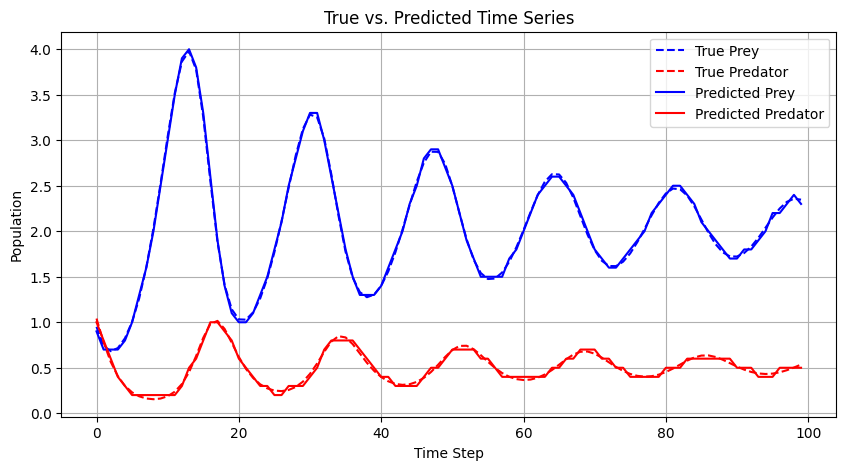

In [ ]:
# Plotting true vs predicted
import matplotlib.pyplot as plt

# Get true values from dataset
true_values = trajectories[0, :, :]  # All time steps for system 0 (prey, predator)
predicted_values = decoded_values  # Model-predicted values

# Plot the true vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(true_values[:, 0], label="True Prey", color="blue", linestyle="dashed")
plt.plot(true_values[:, 1], label="True Predator", color="red", linestyle="dashed")

if predicted_values.shape[0] > 1:  # Ensure predictions exist
    plt.plot(predicted_values[:, 0], label="Predicted Prey", color="blue")
    plt.plot(predicted_values[:, 1], label="Predicted Predator", color="red")

plt.xlabel("Time Step")
plt.ylabel("Population")
plt.title("True vs. Predicted Time Series")
plt.legend()
plt.grid()
plt.savefig("True_VS_Predicted")
plt.show()


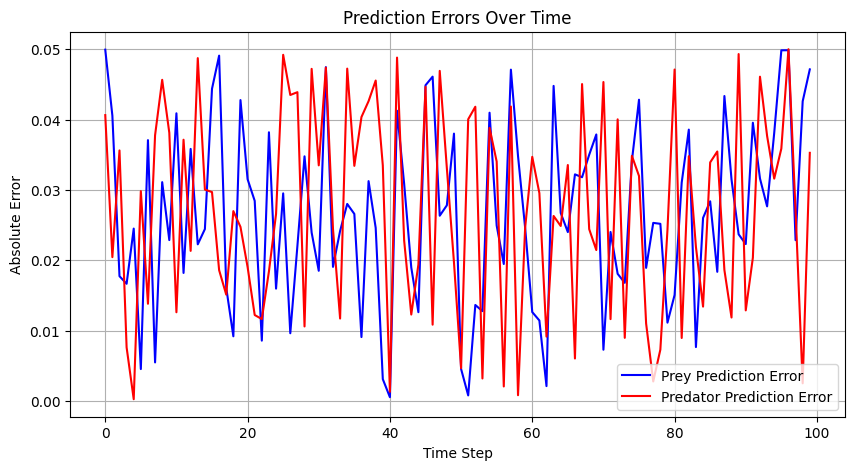

In [ ]:
# Prediction errors plot over time

import numpy as np

# Compute absolute errors
errors = np.abs(true_values - predicted_values)

# Plot error for each variable
plt.figure(figsize=(10, 5))
plt.plot(errors[:, 0], label="Prey Prediction Error", color="blue")
plt.plot(errors[:, 1], label="Predator Prediction Error", color="red")

plt.xlabel("Time Step")
plt.ylabel("Absolute Error")
plt.title("Prediction Errors Over Time")
plt.legend()
plt.grid()
plt.savefig("Absolute_errors")
plt.show()


In [ ]:
# Running the baseline model on all systems
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from properscoring import crps_ensemble

# Load Qwen2.5-Instruct model and tokenizer
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()  # Set to inference mode

# Load preprocessed and tokenized dataset (from 2a)
tokenized_sequences = [tokenize_sequence(seq) for seq in preprocess_time_series(trajectories)]

# Initialize lists to store metrics
mae_list, rmse_list, crps_list = [], [], []

# Loop over all systems
for i, tokenized_seq in enumerate(tokenized_sequences):
    input_tokens = torch.tensor([tokenized_seq])

    # Generate prediction
    with torch.no_grad():
        output_tokens = model.generate(input_tokens, max_length=len(input_tokens[0]) + 5)

    # Decode output back to numerical sequence
    forecasted_sequence = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    decoded_values = decode_sequence(forecasted_sequence, alpha=10)

    # Get true next values from dataset
    true_next_values = trajectories[i, -1, :]  # Last known time step as ground truth

    # Ensure forecasted output is correctly shaped
    if decoded_values.shape[0] > 1:
        predicted_next_values = decoded_values[-1]  # Extract final predicted time step
    else:
        predicted_next_values = np.array([0, 0])  # Fallback if missing data

    # Compute regression metrics
    mae = mean_absolute_error(true_next_values, predicted_next_values)
    rmse = mean_squared_error(true_next_values, predicted_next_values, squared=False)

    # Compute CRPS
    true_distribution = np.expand_dims(true_next_values, axis=0)  # Convert to (1,2) shape
    pred_distribution = np.expand_dims(predicted_next_values, axis=0)  # (1,2) shape
    crps = crps_ensemble(true_distribution, pred_distribution).mean()

    # Store results
    mae_list.append(mae)
    rmse_list.append(rmse)
    crps_list.append(crps)

    print(f"System {i}: MAE={mae:.4f}, RMSE={rmse:.4f}, CRPS={crps:.4f}")

# Compute overall average metrics
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)
avg_crps = np.mean(crps_list)

print("\n--- Final Metrics Across All Systems ---")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average CRPS: {avg_crps:.4f}")


Skipping invalid timestep: '0.22'
System 0: MAE=0.0412, RMSE=0.0416, CRPS=0.0412
Skipping invalid timestep: '0.24'
System 1: MAE=0.0378, RMSE=0.0378, CRPS=0.0378
Skipping invalid timestep: '0.23'
System 2: MAE=0.0253, RMSE=0.0254, CRPS=0.0253
Skipping invalid timestep: '0.05'
System 3: MAE=0.0110, RMSE=0.0148, CRPS=0.0110
Skipping invalid timestep: '0.72'
System 4: MAE=0.0382, RMSE=0.0383, CRPS=0.0382
Skipping invalid timestep: '0.03'
System 5: MAE=0.0287, RMSE=0.0289, CRPS=0.0287
Skipping invalid timestep: '0.25'
System 6: MAE=0.0339, RMSE=0.0356, CRPS=0.0339
Skipping invalid timestep: '0.13'
System 7: MAE=0.0221, RMSE=0.0240, CRPS=0.0221
Skipping invalid timestep: '0.09'
System 8: MAE=0.0273, RMSE=0.0296, CRPS=0.0273
Skipping invalid timestep: '0.02'
System 9: MAE=0.0344, RMSE=0.0346, CRPS=0.0344
Skipping invalid timestep: '0.09'
System 10: MAE=0.0151, RMSE=0.0155, CRPS=0.0151
Error parsing values: ['0.3', '']
System 11: MAE=0.0381, RMSE=0.0382, CRPS=0.0381
Error parsing values: ['0.

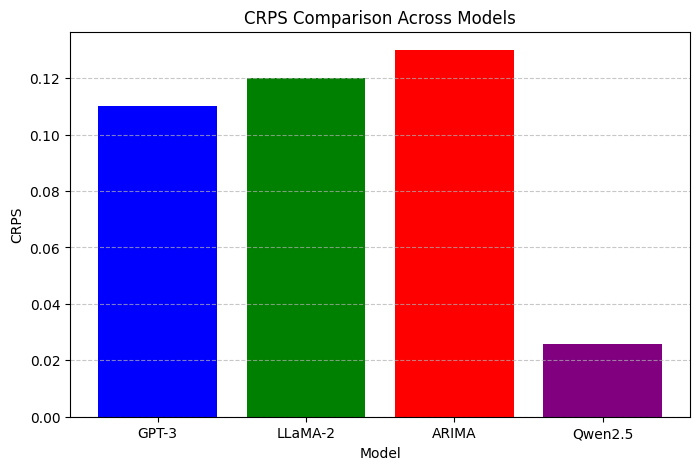

In [ ]:
# A plot that should be taken lightly, compares the Qwen model performance (crps) on our data to 3 models in the paper
# (although the settings of the paper and the data is completely different)
plt.figure(figsize=(8, 5))
models = ["GPT-3", "LLaMA-2", "ARIMA", "Qwen2.5"]
crps_scores = [0.11, 0.12, 0.13, 0.0258]
plt.bar(models, crps_scores, color=["blue", "green", "red", "purple"])

plt.xlabel("Model")
plt.ylabel("CRPS")
plt.title("CRPS Comparison Across Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("crps_scores")
plt.show()


In [ ]:
# Calculating flops
import numpy as np

def calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=False):
    """
    Calculate FLOPS for the forward pass of a transformer-based model like Qwen2.5-Instruct.
    Assumes FLOPS for backpropagation is 2x forward FLOPS.
    """

    # Embedding lookup (not counted as FLOPS, only memory lookup)

    # Multi-Head Attention FLOPS
    head_dim = d_model // n_heads
    attn_flops = (
        3 * d_model * d_model +  # Q, K, V projections (three matrix multiplications)
        seq_len * d_model +       # Scaled dot-product attention
        seq_len * seq_len * d_model +  # Softmax + attention scores
        d_model * d_model  # Output projection
    ) * n_heads * seq_len  # Across all heads and tokens

    # SwiGLU Feedforward FLOPS
    swiglu_flops = (
        2 * d_model * d_ff +  # Two linear projections
        d_ff +                # Elementwise multiplication in GLU
        d_ff * d_model  # Output projection
    ) * seq_len

    # RMSNorm FLOPS (Assume RMSNorm ~ BatchNorm FLOPS)
    rms_norm_flops = (2 * d_model) * seq_len  # Mean, variance calculation & scaling

    # Final Linear Layer FLOPS
    final_layer_flops = seq_len * d_model * vocab_size

    # Total FLOPS per layer
    flops_per_layer = attn_flops + swiglu_flops + rms_norm_flops

    # Total FLOPS for the whole model (forward pass)
    total_flops = n_layers * flops_per_layer + final_layer_flops

    # Account for training (backpropagation is 2x forward pass)
    if training:
        total_flops *= 3  # Forward + Backward (2x forward)

    return total_flops

# Example usage (Qwen2.5-0.5B-Instruct approx hyperparameters)
n_layers = 24  # Transformer layers
d_model = 1024  # Hidden size
n_heads = 16  # Attention heads
d_ff = 4 * d_model  # Feedforward dimension
seq_len = 512  # Token sequence length
vocab_size = 50257  # Approximate vocab size

flops_inference = calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=False)
flops_training = calculate_flops(n_layers, d_model, n_heads, d_ff, seq_len, vocab_size, training=True)

print(f"Inference FLOPS: {flops_inference:.2e}")
print(f"Training FLOPS: {flops_training:.2e}")


Inference FLOPS: 5.39e+13
Training FLOPS: 1.62e+14


In [ ]:
# Question 3.

In [6]:
def preprocess_time_series(file_path, alpha=1, decimal_places=3):
    with h5py.File(file_path, "r") as f:
        dataset_name = list(f.keys())[0]  # Pick the first available dataset
        data = f[dataset_name][()]  # Load the data

    # Convert data if it's a string or bytes
    if isinstance(data, str):
        data = np.array(data.split(), dtype=np.float32)
    elif isinstance(data, bytes):
        data = np.frombuffer(data, dtype=np.float32)
    elif isinstance(data, list):
        data = np.array(data, dtype=np.float32)

    print("Processed data type:", type(data))

    # Scale and round values
    scaled_data = np.round(data / alpha, decimals=decimal_places)
    return scaled_data


In [7]:

@torch.no_grad()
def evaluate_validation_loss(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_batches = 0

    for batch in val_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss.item()
        total_loss += loss
        total_batches += 1

    model.train()
    return total_loss / total_batches if total_batches > 0 else float('inf')


In [8]:
# Implementing full model without hyperparameter tuning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from qwen import load_qwen
import random
import numpy as np
import torch

def set_seed(seed=43):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(43)



# LoRA implementation
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear), "LoRA must wrap an nn.Linear layer."

        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False  # Freeze base weights
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False

        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        # LoRA trainable parameters
        self.A = nn.Parameter(torch.randn(r, in_dim) * 0.01)
        self.B = nn.Parameter(torch.zeros(out_dim, r))

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = x @ self.A.T @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)

# Load Qwen2.5-Instruct model
model, tokenizer = load_qwen()

# Apply LoRA to Q and V projection layers
lora_rank = 4
for layer in model.model.layers:
    if isinstance(layer.self_attn.q_proj, nn.Linear):
        layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    if isinstance(layer.self_attn.v_proj, nn.Linear):
        layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

# Load training data
data = preprocess_time_series("lotka_volterra_data.h5")  # Returns a single numpy array
train_size = int(0.8 * len(data))  # 80% training, 20% validation
train_texts, val_texts = data[:train_size], data[train_size:]


# Tokenization
import torch
from torch.nn.utils.rnn import pad_sequence

def tokenize_and_chunk(texts, tokenizer, max_length=512, stride=256):
    input_ids = []

    for text in texts:
        text = str(text)  # Ensure text format
        tokens = tokenizer.encode(text, add_special_tokens=True)

        if len(tokens) == 0:
            print(f"Warning: Empty tokenized sequence for text: {text}")
            continue  # Skip empty cases

        for i in range(0, max(1, len(tokens) - max_length), stride):
            input_ids.append(torch.tensor(tokens[i : i + max_length]))

    if len(input_ids) == 0:
        raise ValueError("Tokenization produced an empty dataset!")

    # **Pad sequences to match the longest sequence**
    padded_inputs = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

    return padded_inputs  # Returns a 2D Tensor





train_inputs = tokenize_and_chunk(train_texts, tokenizer)
val_inputs = tokenize_and_chunk(val_texts, tokenizer)

# Create Datasets
train_dataset = TensorDataset(train_inputs)
val_dataset = TensorDataset(val_inputs)

g = torch.Generator()
g.manual_seed(43)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=8, generator=g)


# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
accelerator = Accelerator()
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

# Training Loop

num_epochs = 50  # Train for 50 full passes over data

# Initialize lists to store losses
train_losses = []
val_losses = []
step_log = []

num_optimizer_steps = 10_000
current_step = 0

for epoch in range(1000):  # Large enough to reach 10,000 steps
    for step, batch in enumerate(train_loader):
        if current_step >= num_optimizer_steps:
            break  # Stop once we hit 10,000 steps

        inputs = batch[0].to(device)
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss

        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        # Store training loss
        train_losses.append(loss.item())
        step_log.append(current_step)

        # Evaluate validation loss every 1000 steps
        if current_step % 1000 == 0:
            val_loss = evaluate_validation_loss(model, val_loader, device)
            val_losses.append(val_loss)
            print(f"Step {current_step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

        current_step += 1

    if current_step >= num_optimizer_steps:
        break  # Stop training after reaching 10,000 steps

print("Training Complete.")

# Print stored losses AFTER training
print("\nFinal Training Losses (every step):")
print(train_losses)

print("\nFinal Validation Losses (every 1000 steps):")
print(val_losses)


Processed data type: <class 'numpy.ndarray'>
Step 0: Train Loss = 3.9386, Val Loss = 4.0483
Step 1000: Train Loss = 0.4570, Val Loss = 2.2185
Step 2000: Train Loss = 0.4231, Val Loss = 2.5971
Step 3000: Train Loss = 0.3790, Val Loss = 2.7887
Step 4000: Train Loss = 0.3863, Val Loss = 2.7832
Step 5000: Train Loss = 0.5419, Val Loss = 3.0408
Step 6000: Train Loss = 0.4667, Val Loss = 3.1383
Step 7000: Train Loss = 0.5675, Val Loss = 3.2161
Step 8000: Train Loss = 0.4566, Val Loss = 3.1635
Step 9000: Train Loss = 0.3729, Val Loss = 3.2523
Training Complete.

Final Training Losses (every step):
[3.9386367797851562, 4.254103660583496, 4.006324768066406, 4.39796781539917, 3.8591012954711914, 4.022698879241943, 3.7853801250457764, 5.46117639541626, 3.5844290256500244, 4.2488694190979, 3.3384621143341064, 4.668900012969971, 3.856489419937134, 3.1079156398773193, 3.307095527648926, 4.710369110107422, 3.3007583618164062, 3.8155081272125244, 3.2468578815460205, 2.919924736022949, 2.78289723396301

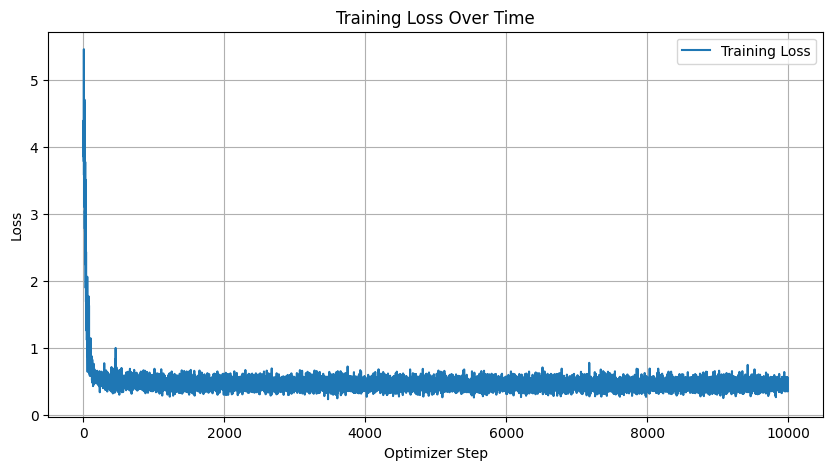

In [ ]:
import matplotlib.pyplot as plt

# 1. Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Optimizer Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.savefig("Original_Training_loss")
plt.show()



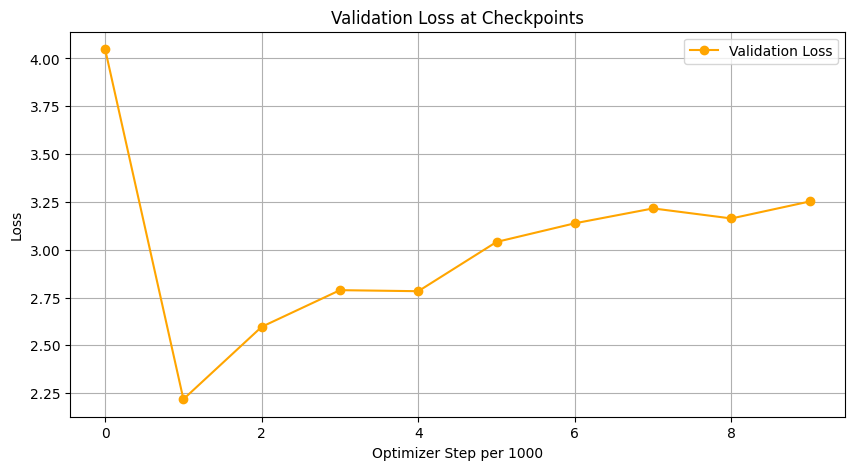

In [ ]:
# 2. Validation Loss Curve

plt.figure(figsize=(10, 5))
plt.plot(val_losses, marker='o', label="Validation Loss", color="orange")
plt.xlabel("Optimizer Step per 1000")
plt.ylabel("Loss")
plt.title("Validation Loss at Checkpoints")
plt.legend()
plt.grid(True)
plt.savefig("Original_Validation_loss")
plt.show()

In [9]:
# Overfitting on a small batch
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



small_batch = next(iter(train_loader))  # returns one batch (tuple of input tensors)
inputs = small_batch[0].to(device)

model.train()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


losses = []

for step in range(1000):
    outputs = model(inputs, labels=inputs)
    loss = outputs.loss
    losses.append(loss.item())

    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad()

    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss.item():.4f}")


Step 0: Loss = 0.4013
Step 100: Loss = 0.0883
Step 200: Loss = 0.0717
Step 300: Loss = 0.0698
Step 400: Loss = 0.0693
Step 500: Loss = 0.0691
Step 600: Loss = 0.0689
Step 700: Loss = 0.0689
Step 800: Loss = 0.0688
Step 900: Loss = 0.0688


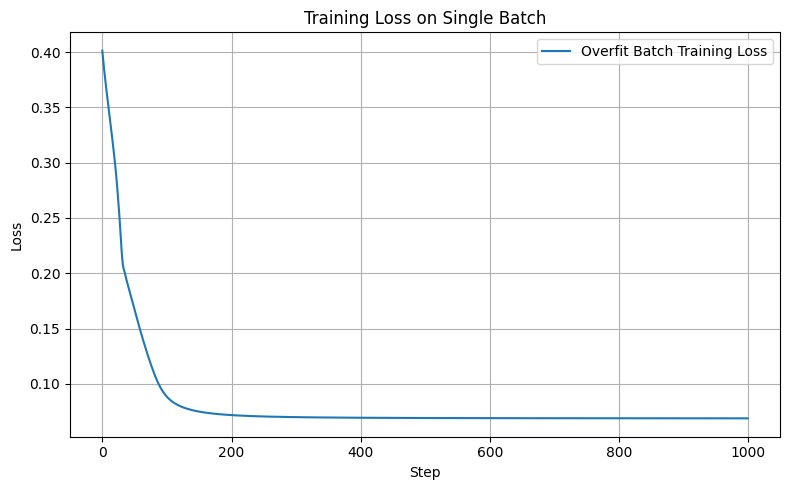

In [ ]:
import matplotlib.pyplot as plt

# ---- Overfit Batch Training Loss ----
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Overfit Batch Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss on Single Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Overfitting_Training_loss")
plt.show()


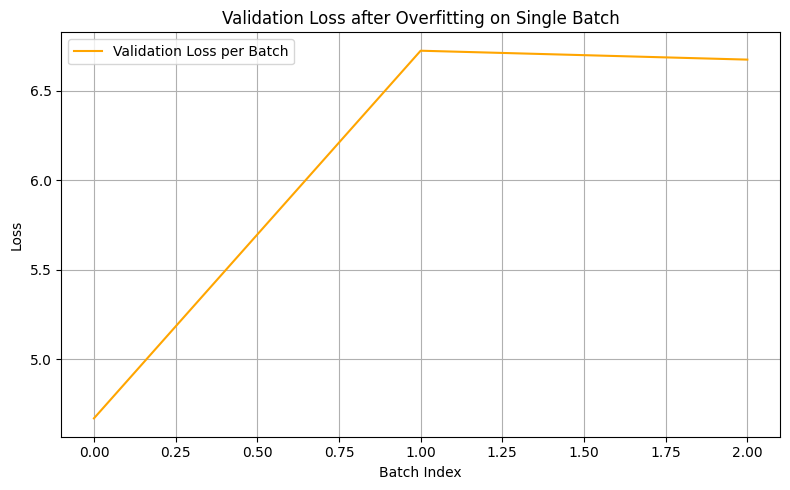

In [ ]:
# Plotting the overfitting batch validation loss
def evaluate_validation_loss(model, val_loader, device):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs, labels=inputs)
            val_losses.append(outputs.loss.item())

    return val_losses  # Returns loss for each batch

val_losses_overfit = evaluate_validation_loss(model, val_loader, device)

# ---- Validation Loss Plot ----
plt.figure(figsize=(8, 5))
plt.plot(val_losses_overfit, label="Validation Loss per Batch", color='orange')
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Validation Loss after Overfitting on Single Batch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Overfitting_Validation_loss")
plt.show()


In [ ]:
# Part b)
def train_lora_model(lora_rank, learning_rate, train_loader, val_loader, tokenizer, device, seed=43):
    set_seed(seed)

    model, _ = load_qwen()
    for layer in model.model.layers:
        if isinstance(layer.self_attn.q_proj, nn.Linear):
            layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
        if isinstance(layer.self_attn.v_proj, nn.Linear):
            layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

    model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    accelerator = Accelerator()
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

    train_losses = []
    val_losses = []
    step_log = []

    current_step = 0
    for epoch in range(1000):
        for step, batch in enumerate(train_loader):
            if current_step >= 10_000:
                break

            inputs = batch[0].to(device)
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(loss.item())
            step_log.append(current_step)

            if current_step % 1000 == 0:
                val_loss = evaluate_validation_loss(model, val_loader, device)
                val_losses.append(val_loss)
                print(f"[Rank={lora_rank}, LR={learning_rate}] Step {current_step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss[0]:.4f}")


            current_step += 1

        if current_step >= 10_000:
            break

    return {
        'lora_rank': lora_rank,
        'learning_rate': learning_rate,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }


In [ ]:
lora_ranks = [2, 4, 8]
learning_rates = [1e-5, 5e-5, 1e-4]
results = []

for rank in lora_ranks:
    for lr in learning_rates:
        print(f"\n Running LoRA Rank={rank}, LR={lr}")
        result = train_lora_model(rank, lr, train_loader, val_loader, tokenizer, device)
        results.append(result)



 Running LoRA Rank=2, LR=1e-05
[Rank=2, LR=1e-05] Step 0: Train Loss = 4.3053, Val Loss = 3.4250
[Rank=2, LR=1e-05] Step 1000: Train Loss = 0.7923, Val Loss = 1.8684
[Rank=2, LR=1e-05] Step 2000: Train Loss = 0.7288, Val Loss = 2.1603
[Rank=2, LR=1e-05] Step 3000: Train Loss = 0.5605, Val Loss = 2.4152
[Rank=2, LR=1e-05] Step 4000: Train Loss = 0.6002, Val Loss = 2.5292
[Rank=2, LR=1e-05] Step 5000: Train Loss = 0.4906, Val Loss = 2.5370
[Rank=2, LR=1e-05] Step 6000: Train Loss = 0.5056, Val Loss = 2.7059
[Rank=2, LR=1e-05] Step 7000: Train Loss = 0.5119, Val Loss = 2.8560
[Rank=2, LR=1e-05] Step 8000: Train Loss = 0.4141, Val Loss = 2.9961
[Rank=2, LR=1e-05] Step 9000: Train Loss = 0.5081, Val Loss = 3.1079

 Running LoRA Rank=2, LR=5e-05
[Rank=2, LR=5e-05] Step 0: Train Loss = 3.6870, Val Loss = 3.4237
[Rank=2, LR=5e-05] Step 1000: Train Loss = 0.5802, Val Loss = 2.2068
[Rank=2, LR=5e-05] Step 2000: Train Loss = 0.4478, Val Loss = 2.5135
[Rank=2, LR=5e-05] Step 3000: Train Loss = 0.

In [ ]:
best_result = min(results, key=lambda x: x['val_losses'][-1][0])

print("\n Best Model (by final validation loss):")
print(f"  Rank: {best_result['lora_rank']}")
print(f"  Learning Rate: {best_result['learning_rate']}")
print(f"  Final Validation Loss: {best_result['val_losses'][-1][0]:.4f}")
print(f"  Final Training Loss: {best_result['train_losses'][-1]:.4f}")




 Best Model (by final validation loss):
  Rank: 4
  Learning Rate: 5e-05
  Final Validation Loss: 2.0819
  Final Training Loss: 0.4503


In [ ]:
# Outputting full results of the grid search
import pandas as pd

# Collect all results from grid search
rows = []
for result in results:
    rows.append({
        "LoRA Rank": result['lora_rank'],
        "Learning Rate": result['learning_rate'],
        "Final Train Loss": result['train_losses'][-1],
        "Final Val Loss": result['val_losses'][-1],
    })

df = pd.DataFrame(rows)
df.to_csv("lora_gridsearch_results.csv", index=False)
print(df)


   LoRA Rank  Learning Rate  Final Train Loss  \
0          2        0.00001          0.524243   
1          2        0.00005          0.373706   
2          2        0.00010          0.539039   
3          4        0.00001          0.462347   
4          4        0.00005          0.450347   
5          4        0.00010          0.512973   
6          8        0.00001          0.505612   
7          8        0.00005          0.457033   
8          8        0.00010          0.421910   

                                      Final Val Loss  
0  [3.1078789234161377, 2.3590054512023926, 3.991...  
1  [2.9428608417510986, 3.424856185913086, 3.2114...  
2  [2.4040918350219727, 2.5325703620910645, 3.097...  
3  [3.3509528636932373, 1.8535423278808594, 4.816...  
4  [2.081912040710449, 2.385495901107788, 4.58921...  
5  [2.7012860774993896, 2.933759927749634, 4.3651...  
6  [2.584045886993408, 1.8591581583023071, 4.6902...  
7  [2.925852060317993, 2.363402843475342, 3.74463...  
8  [2.46893692

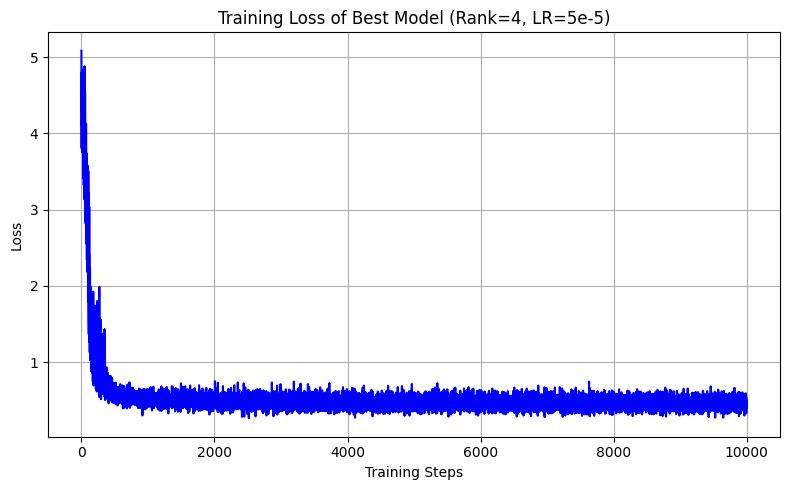

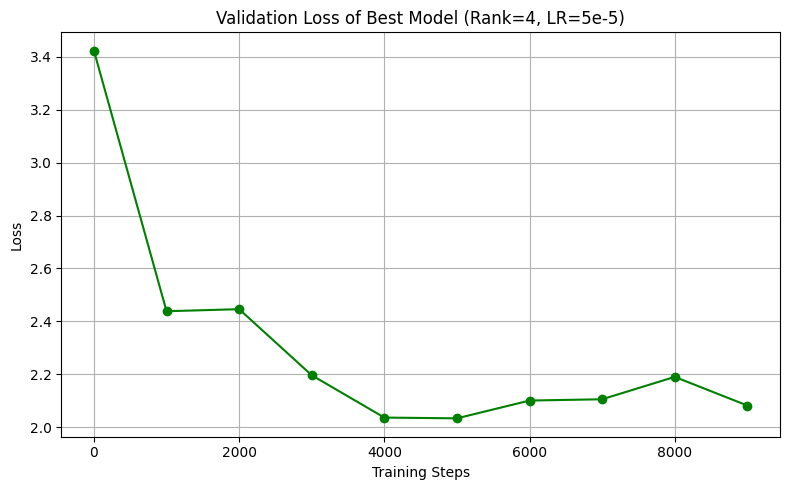

In [ ]:
# Plotting best model from grid search

import matplotlib.pyplot as plt

# Unpack losses and steps
train_losses = best_result['train_losses']
val_losses = [v[0] if isinstance(v, (list, tuple)) else v for v in best_result['val_losses']]
val_steps = list(range(0, 10001, 1000))  # Validation every 1000 steps
train_steps = list(range(len(train_losses)))

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, label="Train Loss", color='blue')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss of Best Model (Rank=4, LR=5e-5)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Best_Model_Train_Loss")
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(val_steps[:len(val_losses)], val_losses, label="Validation Loss", color='green', marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Validation Loss of Best Model (Rank=4, LR=5e-5)")
plt.grid(True)
plt.tight_layout()
plt.savefig("Best_Model_Val_Loss")
plt.show()


In [ ]:
# Now experimenting with context lengths

In [10]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, context_length):
        self.examples = []
        for text in texts:
            tokenized = tokenizer(
                text,
                return_tensors='pt',
                padding='max_length',
                truncation=True,
                max_length=context_length
            )
            input_ids = tokenized['input_ids'].squeeze(0)
            self.examples.append(input_ids)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx],  # return as a tuple

def make_dataloader(texts, tokenizer, context_length, batch_size):
    dataset = TextDataset(texts, tokenizer, context_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [11]:
def train_lora_model(
    lora_rank,
    learning_rate,
    train_texts,
    val_texts,
    tokenizer,
    device,
    context_length=128,
    max_steps=30000,
    seed=42
):
    set_seed(seed)

    # Tokenize and prepare data loaders
    train_loader = make_dataloader(train_texts, tokenizer, context_length, batch_size=1)
    val_loader = make_dataloader(val_texts, tokenizer, context_length, batch_size=1)

    model, _ = load_qwen()

    for layer in model.model.layers:
        if isinstance(layer.self_attn.q_proj, nn.Linear):
            layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
        if isinstance(layer.self_attn.v_proj, nn.Linear):
            layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

    model.to(device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    accelerator = Accelerator()
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

    train_losses = []
    val_losses = []
    step_log = []

    current_step = 0
    for epoch in range(1000):  # Loop over epochs until max_steps is hit
        for batch in train_loader:
            if current_step >= max_steps:
                break

            inputs = batch[0].to(device)
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss

            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(loss.item())
            step_log.append(current_step)

            # Validation every 500 steps
            if current_step % 500 == 0:
                val_loss = evaluate_validation_loss(model, val_loader, device)
                val_losses.append(val_loss)
                print(f"[Rank={lora_rank}, LR={learning_rate}, Ctx={context_length}] Step {current_step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

            current_step += 1

        if current_step >= max_steps:
            break

    return {
        'lora_rank': lora_rank,
        'learning_rate': learning_rate,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'context_length': context_length,
        'max_steps': max_steps,
    }


In [12]:
def preprocess_time_series(file_path, alpha=1, decimal_places=3):
    with h5py.File(file_path, "r") as f:
        dataset_name = list(f.keys())[0]  # Pick the first available dataset
        data = f[dataset_name][()]  # Load the data

    # Convert data if it's a string or bytes
    if isinstance(data, str):
        data = np.array(data.split(), dtype=np.float32)
    elif isinstance(data, bytes):
        data = np.frombuffer(data, dtype=np.float32)
    elif isinstance(data, list):
        data = np.array(data, dtype=np.float32)

    print("Processed data type:", type(data))

    # Scale and round values
    scaled_data = np.round(data / alpha, decimals=decimal_places)
    return scaled_data


In [13]:
@torch.no_grad()
def evaluate_validation_loss(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_batches = 0

    for batch in val_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs, labels=inputs)
        loss = outputs.loss.item()
        total_loss += loss
        total_batches += 1

    model.train()
    return total_loss / total_batches if total_batches > 0 else float('inf')

In [ ]:
result = train_lora_model(
    lora_rank=4,
    learning_rate=5e-5,
    train_texts=train_texts,
    val_texts=val_texts,
    tokenizer=tokenizer,
    device=device,
    context_length=128,
    max_steps=30000
)


[Rank=4, LR=5e-05, Ctx=128] Step 0: Train Loss = 12.8980, Val Loss = 14.9693
[Rank=4, LR=5e-05, Ctx=128] Step 500: Train Loss = 0.1336, Val Loss = 0.2187
[Rank=4, LR=5e-05, Ctx=128] Step 1000: Train Loss = 0.1105, Val Loss = 0.1396
[Rank=4, LR=5e-05, Ctx=128] Step 1500: Train Loss = 0.0943, Val Loss = 0.0970
[Rank=4, LR=5e-05, Ctx=128] Step 2000: Train Loss = 0.0434, Val Loss = 0.0978
[Rank=4, LR=5e-05, Ctx=128] Step 2500: Train Loss = 0.0456, Val Loss = 0.0960
[Rank=4, LR=5e-05, Ctx=128] Step 3000: Train Loss = 0.0150, Val Loss = 0.0957
[Rank=4, LR=5e-05, Ctx=128] Step 3500: Train Loss = 0.0409, Val Loss = 0.0974
[Rank=4, LR=5e-05, Ctx=128] Step 4000: Train Loss = 0.0388, Val Loss = 0.0978
[Rank=4, LR=5e-05, Ctx=128] Step 4500: Train Loss = 0.0373, Val Loss = 0.1079
[Rank=4, LR=5e-05, Ctx=128] Step 5000: Train Loss = 0.0441, Val Loss = 0.1064
[Rank=4, LR=5e-05, Ctx=128] Step 5500: Train Loss = 0.0351, Val Loss = 0.1072
[Rank=4, LR=5e-05, Ctx=128] Step 6000: Train Loss = 0.0182, Val Lo

In [14]:
# Ensure your text data is in string format
train_texts = [str(t) for t in train_texts]
val_texts = [str(t) for t in val_texts]

context_lengths = [128, 512, 768]
context_results = []

for context_length in context_lengths:
    print(f"\nTraining with context length = {context_length}")

    result = train_lora_model(
        lora_rank=4,
        learning_rate=5e-5,
        train_texts=train_texts,
        val_texts=val_texts,
        tokenizer=tokenizer,
        device=device,
        context_length=context_length,
        max_steps=2000,  # Trial run
    )

    result["context_length"] = context_length
    context_results.append(result)



Training with context length = 128
[Rank=4, LR=5e-05, Ctx=128] Step 0: Train Loss = 12.8980, Val Loss = 14.9693
[Rank=4, LR=5e-05, Ctx=128] Step 500: Train Loss = 0.1336, Val Loss = 0.2187
[Rank=4, LR=5e-05, Ctx=128] Step 1000: Train Loss = 0.1105, Val Loss = 0.1396
[Rank=4, LR=5e-05, Ctx=128] Step 1500: Train Loss = 0.0943, Val Loss = 0.0970

Training with context length = 512
[Rank=4, LR=5e-05, Ctx=512] Step 0: Train Loss = 11.1752, Val Loss = 12.4621
[Rank=4, LR=5e-05, Ctx=512] Step 500: Train Loss = 0.0599, Val Loss = 0.0641
[Rank=4, LR=5e-05, Ctx=512] Step 1000: Train Loss = 0.0387, Val Loss = 0.0483
[Rank=4, LR=5e-05, Ctx=512] Step 1500: Train Loss = 0.0268, Val Loss = 0.0380

Training with context length = 768
[Rank=4, LR=5e-05, Ctx=768] Step 0: Train Loss = 10.4602, Val Loss = 11.3191
[Rank=4, LR=5e-05, Ctx=768] Step 500: Train Loss = 0.0418, Val Loss = 0.0588
[Rank=4, LR=5e-05, Ctx=768] Step 1000: Train Loss = 0.0275, Val Loss = 0.0342
[Rank=4, LR=5e-05, Ctx=768] Step 1500: T

In [15]:
# Find the best model based on final validation loss
best_result = min(
    context_results,
    key=lambda r: r["val_losses"][-1]  # compare final val loss
)

print("\nBest Model Based on Final Validation Loss:")
print(f"  Context Length: {best_result['context_length']}")
print(f"  Final Validation Loss: {best_result['val_losses'][-1]:.4f}")
print(f"  Final Training Loss: {best_result['train_losses'][-1]:.4f}")



Best Model Based on Final Validation Loss:
  Context Length: 768
  Final Validation Loss: 0.0277
  Final Training Loss: 0.0183


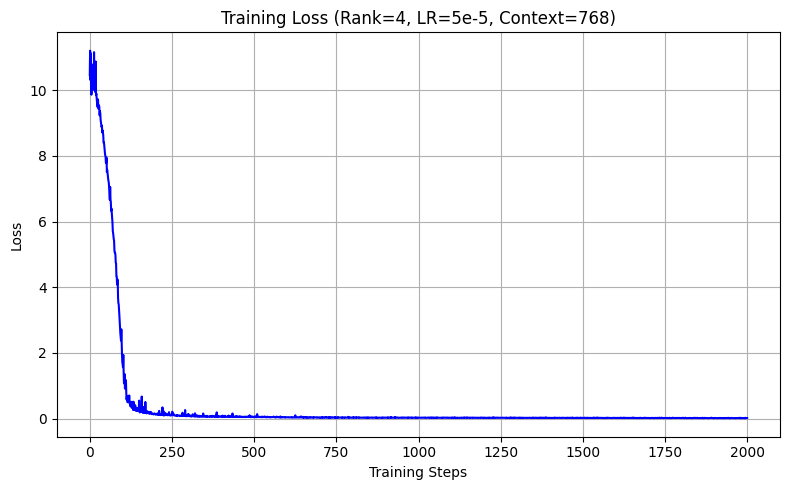

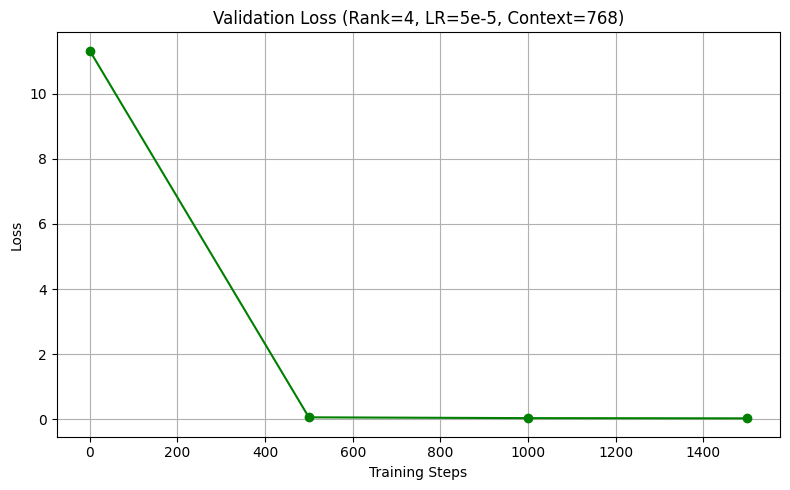

In [19]:
# Plotting the validation and training loss for only 2000 steps
import matplotlib.pyplot as plt

# Extract loss and steps
train_losses = best_result['train_losses']
val_losses = best_result['val_losses']
train_steps = list(range(len(train_losses)))
val_steps = list(range(0, len(train_losses), 500))[:len(val_losses)]  # assuming val loss every 500 steps

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, label="Training Loss", color='blue')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss (Rank=4, LR=5e-5, Context=768)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(val_steps, val_losses, label="Validation Loss", color='green', marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Validation Loss (Rank=4, LR=5e-5, Context=768)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
# We run the model for 30000 steps
# Ensure text is string format
train_texts = [str(t) for t in train_texts]
val_texts = [str(t) for t in val_texts]

# Train best model on full run
best_model_result = train_lora_model(
    lora_rank=4,
    learning_rate=5e-5,
    train_texts=train_texts,
    val_texts=val_texts,
    tokenizer=tokenizer,
    device=device,
    context_length=768,
    max_steps=30000  # Full training
)


[Rank=4, LR=5e-05, Ctx=768] Step 0: Train Loss = 10.4602, Val Loss = 11.3191
[Rank=4, LR=5e-05, Ctx=768] Step 500: Train Loss = 0.0573, Val Loss = 0.0571
[Rank=4, LR=5e-05, Ctx=768] Step 1000: Train Loss = 0.0271, Val Loss = 0.0336
[Rank=4, LR=5e-05, Ctx=768] Step 1500: Train Loss = 0.0213, Val Loss = 0.0276
[Rank=4, LR=5e-05, Ctx=768] Step 2000: Train Loss = 0.0130, Val Loss = 0.0211
[Rank=4, LR=5e-05, Ctx=768] Step 2500: Train Loss = 0.0112, Val Loss = 0.0178
[Rank=4, LR=5e-05, Ctx=768] Step 3000: Train Loss = 0.0057, Val Loss = 0.0161
[Rank=4, LR=5e-05, Ctx=768] Step 3500: Train Loss = 0.0076, Val Loss = 0.0155
[Rank=4, LR=5e-05, Ctx=768] Step 4000: Train Loss = 0.0078, Val Loss = 0.0154
[Rank=4, LR=5e-05, Ctx=768] Step 4500: Train Loss = 0.0063, Val Loss = 0.0150
[Rank=4, LR=5e-05, Ctx=768] Step 5000: Train Loss = 0.0176, Val Loss = 0.0145
[Rank=4, LR=5e-05, Ctx=768] Step 5500: Train Loss = 0.0076, Val Loss = 0.0143
[Rank=4, LR=5e-05, Ctx=768] Step 6000: Train Loss = 0.0039, Val Lo

In [21]:
# Print final training and validation loss
final_train_loss = best_model_result['train_losses'][-1]
final_val_loss = best_model_result['val_losses'][-1]  # Assuming it's a float, not a list

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Loss: 0.0030
Final Validation Loss: 0.0171


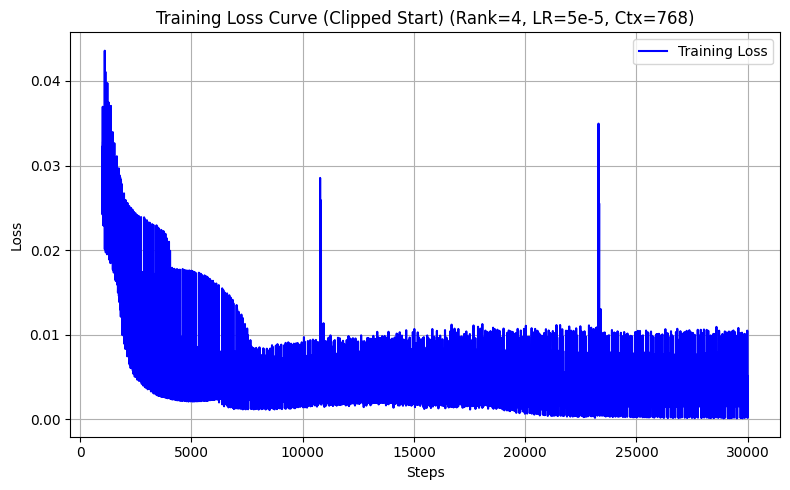

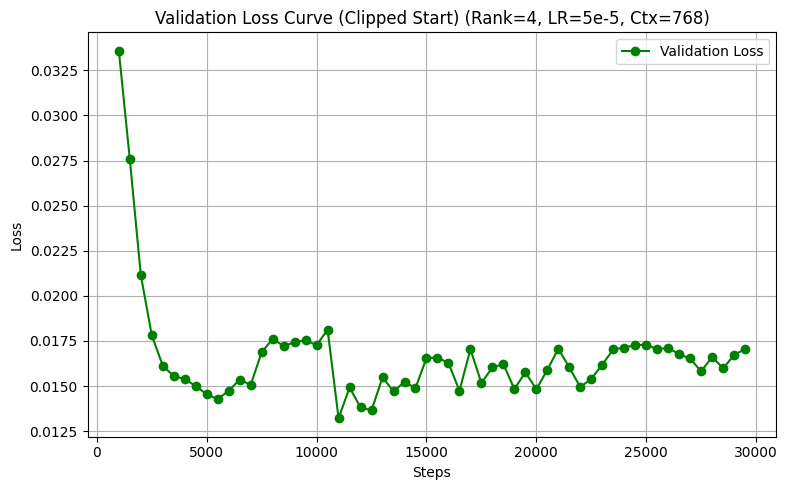

In [24]:
import matplotlib.pyplot as plt

train_losses = best_model_result['train_losses']
val_losses = best_model_result['val_losses']

# Handle val_loss format if each is a list (e.g., [[0.12], [0.10], ...])
if isinstance(val_losses[0], list):
    val_losses = [v[0] for v in val_losses]

# Clip the first N steps
clip_start = 1000  # Number of training steps to skip for better visualization

# Steps
train_steps = list(range(len(train_losses)))
train_steps_clipped = train_steps[clip_start:]
train_losses_clipped = train_losses[clip_start:]

# Adjust validation steps accordingly
val_interval = len(train_steps) // len(val_losses)
val_steps = list(range(0, len(train_losses), val_interval))
val_steps_clipped = [step for step in val_steps if step >= clip_start]
val_losses_clipped = val_losses[-len(val_steps_clipped):]  # Match remaining length

# Plot Training Loss (clipped)
plt.figure(figsize=(8, 5))
plt.plot(train_steps_clipped, train_losses_clipped, label="Training Loss", color='blue')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Clipped Start) (Rank=4, LR=5e-5, Ctx=768)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Best_Training_Loss_Clipped")
plt.show()

# Plot Validation Loss (clipped)
plt.figure(figsize=(8, 5))
plt.plot(val_steps_clipped, val_losses_clipped, label="Validation Loss", color='green', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss Curve (Clipped Start) (Rank=4, LR=5e-5, Ctx=768)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Best_Validation_Loss_Clipped")
plt.show()


In [ ]:
# Flops calculation

def estimate_flops_per_step(seq_len, hidden_size=4096, num_layers=32, num_heads=32):
    """
    Estimate the FLOPS per forward+backward training step of a transformer model.

    Based on: 2 × (#Params × SeqLen) + Attention FLOPS (quadratic) × Layers
    This is a rough estimate for comparative purposes.

    Args:
        seq_len (int): Input context length (sequence length).
        hidden_size (int): Model hidden size (e.g., 4096 for Qwen2.5 0.5B).
        num_layers (int): Number of transformer layers.
        num_heads (int): Number of attention heads.

    Returns:
        float: Estimated FLOPS per training step.
    """
    # MLP and attention projection params
    params_per_layer = 12 * hidden_size ** 2
    total_params = num_layers * params_per_layer

    # FLOPS from parameter multiplications
    param_flops = 2 * total_params * seq_len  # fwd + bwd

    # FLOPS from self-attention
    attn_flops = num_layers * 2 * seq_len ** 2 * hidden_size

    return param_flops + attn_flops


In [ ]:
seq_lengths = [128, 512, 768]
for seq in seq_lengths:
    flops = estimate_flops_per_step(seq)
    print(f"Estimated FLOPS per step (context {seq}): {flops:.2e}")


Estimated FLOPS per step (context 128): 1.65e+12
Estimated FLOPS per step (context 512): 6.67e+12
Estimated FLOPS per step (context 768): 1.01e+13
